## Content:

1. [Load and Check Data](#1)
2. [Visualize the Data](#2)
3. [ADF Test](#3)
4. [Differencing](#4)
5. [Auto Regressive Model](#5)
6. [Linear Regression](#6)

<a id="1"></a>
# 1) Load an Check Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import datetime

In [39]:
train_df = pd.read_excel("Case_Study.xlsx")

In [40]:
#check duplicated dates
train_df[train_df.Day.duplicated()]['Day'].count()

0

In [41]:
print('Starting date of the data: ', train_df.Day.min())
print('Ending date of the data: ', train_df.Day.max())
print('Total number of days in available historical data: ', train_df.Day.nunique())

Starting date of the data:  2020-01-01 00:00:00
Ending date of the data:  2022-04-20 00:00:00
Total number of days in available historical data:  601


In [5]:
#0 Monday
train_df.groupby(train_df.Day.dt.dayofweek).count()[['Deposit']].rename(columns={'Deposit': 'count'})

,count
Day,
0,120
1,120
2,121
3,120
4,120


/Users/asliesi/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


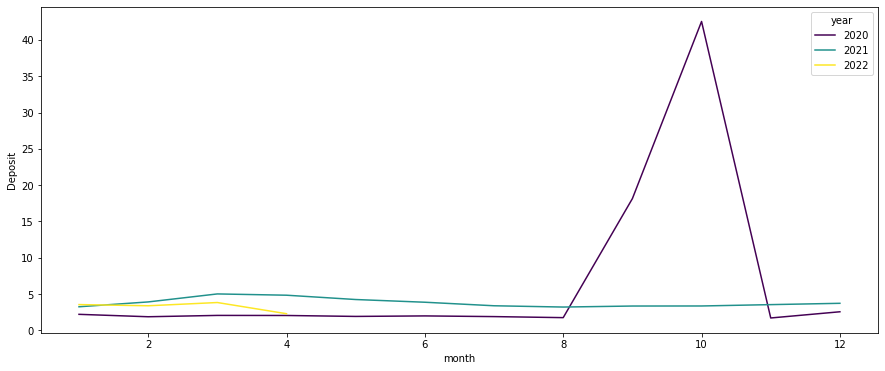

In [6]:
by_years = train_df[['Day', 'Deposit']].copy()
by_years['year'] = by_years.Day.dt.year
by_years['month'] = by_years.Day.dt.month
by_years = by_years.groupby(['year', 'month']).sum().reset_index()

plt.close()
palette ="viridis"
fig, ax = plt.subplots(figsize=(15, 6))
ax = sns.lineplot(by_years['month'], by_years['Deposit'], hue=by_years['year'], ax=ax, palette=palette)
plt.show()

In [42]:
df = train_df.copy()
df = df.drop('Unnamed: 6', axis=1)
df

,Day,OIS3M,OIS6M,OIS1Y,CBT,Deposit
0,2020-01-01,0.1050,0.1050,0.1061,0.1149,0.0977
1,2020-01-02,0.1050,0.1050,0.1066,0.1149,0.0976
2,2020-01-03,0.1068,0.1068,0.1088,0.1129,0.0974
3,2020-01-06,0.1097,0.1102,0.1113,0.1144,0.0973
4,2020-01-07,0.1106,0.1107,0.1111,0.1150,0.0971
...,...,...,...,...,...,...
596,2022-04-14,0.1610,0.1905,0.2365,0.1400,0.1637
597,2022-04-15,0.1575,0.1895,0.2365,0.1400,0.1636
598,2022-04-18,0.1575,0.1895,0.2372,0.1400,0.1634
599,2022-04-19,0.1590,0.1885,0.2357,0.1400,0.1633


In [43]:
# Extra regressors
def regresor_covid_cuarentena(Day):
    date = pd.to_datetime(Day)
    date_covid0=pd.to_datetime('2020-09-10',  format='%Y-%m-%d')
    date_covid1=pd.to_datetime('2020-10-10',  format='%Y-%m-%d')
    if (date > date_covid0) and (date < date_covid1):
        return 1
    return 0

df['covid_cuarentena'] = df['Day'].apply(regresor_covid_cuarentena)

regresores = [c for c in df.columns if c not in ['Day', 'Deposit'] ]

In [44]:
df2 = df[['Day', 'Deposit']].copy()

In [45]:
# Defaults
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 12})
plt.style.use('ggplot')

In [46]:
# A bit of pre-processing to make it nicer
df2['Day']=pd.to_datetime(df2['Day'], format='%Y-%m-%d')
df2.set_index(['Day'], inplace=True)

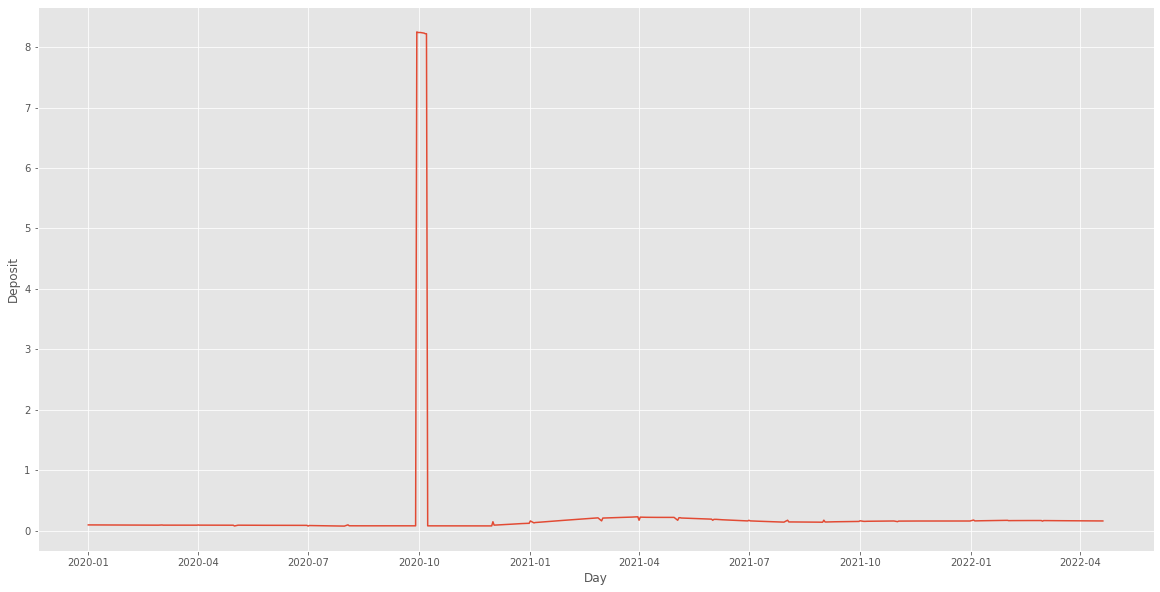

In [47]:
plt.xlabel('Day')
plt.ylabel('Deposit')
plt.plot(df2)

In [48]:
to_drop = df[df['covid_cuarentena']==1]

In [49]:
to_drop

,Day,OIS3M,OIS6M,OIS1Y,CBT,Deposit,covid_cuarentena
182,2020-09-11,0.1225,0.1340,0.1400,0.1029,0.0828,1
183,2020-09-14,0.1224,0.1338,0.1393,0.1032,0.0828,1
184,2020-09-15,0.1221,0.1330,0.1375,0.1033,0.0827,1
185,2020-09-16,0.1215,0.1325,0.1375,0.1032,0.0827,1
186,2020-09-17,0.1255,0.1365,0.1420,0.1041,0.0827,1
187,2020-09-18,0.1269,0.1384,0.1432,0.1039,0.0827,1
188,2020-09-21,0.1285,0.1400,0.1445,0.1061,0.0826,1
189,2020-09-22,0.1300,0.1410,0.1455,0.1061,0.0826,1
190,2020-09-23,0.1300,0.1405,0.1455,0.1065,0.0826,1
191,2020-09-24,0.1315,0.1420,0.1460,0.1069,0.0826,1


In [50]:
df

,Day,OIS3M,OIS6M,OIS1Y,CBT,Deposit,covid_cuarentena
0,2020-01-01,0.1050,0.1050,0.1061,0.1149,0.0977,0
1,2020-01-02,0.1050,0.1050,0.1066,0.1149,0.0976,0
2,2020-01-03,0.1068,0.1068,0.1088,0.1129,0.0974,0
3,2020-01-06,0.1097,0.1102,0.1113,0.1144,0.0973,0
4,2020-01-07,0.1106,0.1107,0.1111,0.1150,0.0971,0
...,...,...,...,...,...,...,...
596,2022-04-14,0.1610,0.1905,0.2365,0.1400,0.1637,0
597,2022-04-15,0.1575,0.1895,0.2365,0.1400,0.1636,0
598,2022-04-18,0.1575,0.1895,0.2372,0.1400,0.1634,0
599,2022-04-19,0.1590,0.1885,0.2357,0.1400,0.1633,0


### 29.09.2020 - 07.10.2020 tarihleri arasında veride bozulma mevcuttur. Ekstra regresör değil. covid etkisi değil
### Bu durumda veriyi düzeltmeye gitmek amacıyla ilgili kayıtları 100'e bölebiliriz. 

In [51]:
data = [train_df]

for dataset in data:
    dataset.loc[(dataset['Deposit'] > 1 ) , 'Deposit'] = dataset['Deposit'] /100
    dataset.loc[(dataset['OIS3M'] > 1 ) , 'OIS3M'] = dataset['OIS3M'] /100
    dataset.loc[(dataset['OIS6M'] > 1 ) , 'OIS6M'] = dataset['OIS6M'] /100
    dataset.loc[(dataset['OIS1Y'] > 1 ) , 'OIS1Y'] = dataset['OIS1Y'] /100    
    dataset.loc[(dataset['CBT'] > 1 ) , 'CBT'] = dataset['CBT'] /100

In [52]:
train_df.iloc[194:201]

,Day,OIS3M,OIS6M,OIS1Y,CBT,Deposit,Unnamed: 6
194,2020-09-29,0.1395,0.1485,0.1485,0.1108,0.0825,NaN
195,2020-09-30,0.1380,0.1461,0.1467,0.1112,0.0824,NaN
196,2020-10-01,0.1380,0.1462,0.1465,0.1120,0.0824,NaN
197,2020-10-02,0.1390,0.1465,0.1465,0.1132,0.0824,NaN
198,2020-10-05,0.1360,0.1450,0.1450,0.1138,0.0823,NaN
199,2020-10-06,0.1353,0.1430,0.1443,0.1145,0.0822,NaN
200,2020-10-07,0.1405,0.1465,0.1465,0.1147,0.0822,NaN


In [53]:
train_df = train_df.drop('Unnamed: 6',axis=1)

In [18]:
# A bit of pre-processing to make it nicer
train_df['Day']=pd.to_datetime(train_df['Day'], format='%Y-%m-%d')
train_df.set_index(['Day'], inplace=True)
train_df

,OIS3M,OIS6M,OIS1Y,CBT,Deposit,Unnamed: 6
Day,,,,,,
2020-01-01,0.1050,0.1050,0.1061,0.1149,0.0977,NaN
2020-01-02,0.1050,0.1050,0.1066,0.1149,0.0976,NaN
2020-01-03,0.1068,0.1068,0.1088,0.1129,0.0974,NaN
2020-01-06,0.1097,0.1102,0.1113,0.1144,0.0973,NaN
2020-01-07,0.1106,0.1107,0.1111,0.1150,0.0971,NaN
...,...,...,...,...,...,...
2022-04-14,0.1610,0.1905,0.2365,0.1400,0.1637,NaN
2022-04-15,0.1575,0.1895,0.2365,0.1400,0.1636,NaN
2022-04-18,0.1575,0.1895,0.2372,0.1400,0.1634,NaN


<a id="2"></a>
# 2) Visualize the Data

<AxesSubplot:xlabel='Day'>

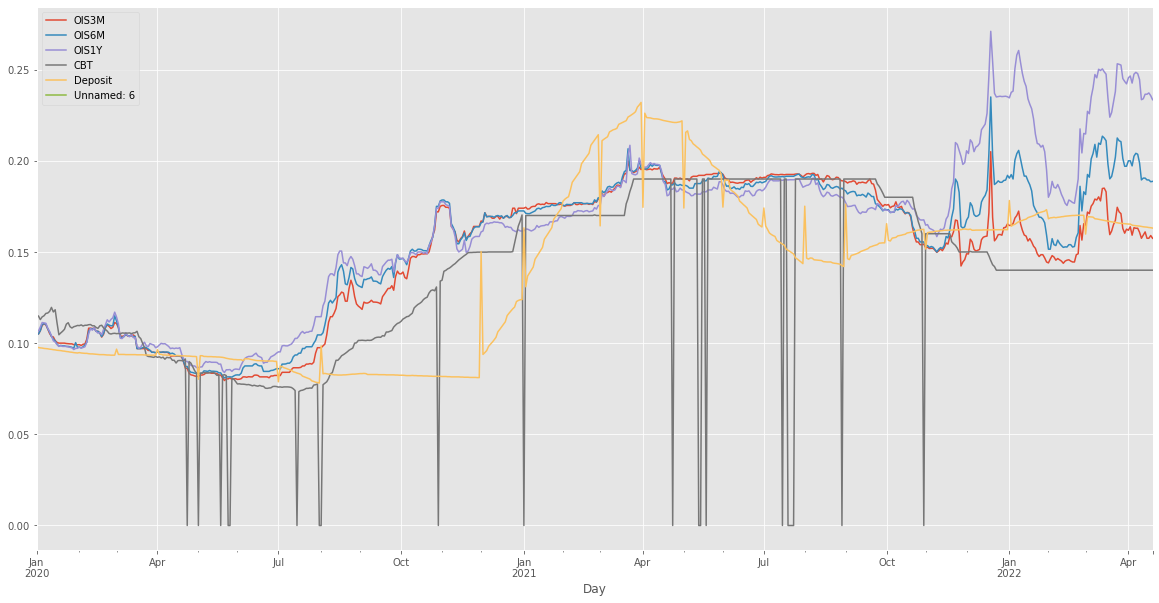

In [19]:
train_df.plot()

<a id="3"></a>
# 3) ADF Test

#Ho: It is non stationary
#H1: It is stationary

In [20]:
test_result=adfuller(train_df['Deposit'])

In [21]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(Deposit):
    result=adfuller(Deposit)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [22]:
adfuller_test(train_df['Deposit'])

ADF Test Statistic : -2.266069681594771
p-value : 0.18314473389666064
#Lags Used : 19
Number of Observations Used : 581
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


<AxesSubplot:xlabel='Day'>

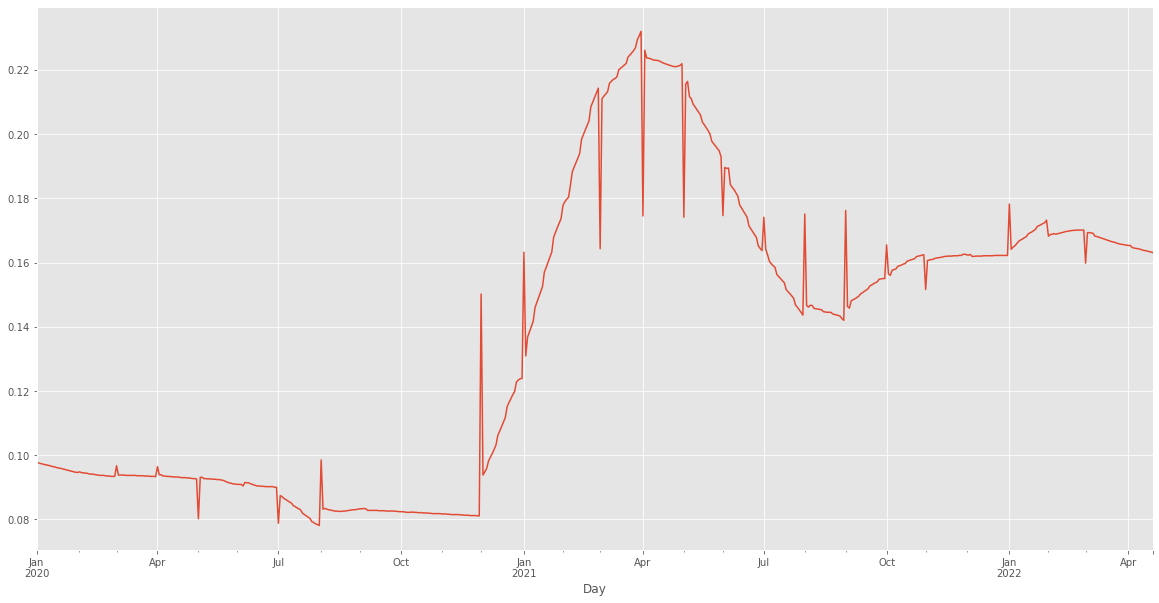

In [23]:
train_df['Deposit'].plot()

<a id="4"></a>
# 4) Differencing

In [24]:
train_df['Deposit First Difference'] = train_df['Deposit'] - train_df['Deposit'].shift(1)

In [25]:
train_df['Deposit'].shift(1)

Day
2020-01-01       NaN
2020-01-02    0.0977
2020-01-03    0.0976
2020-01-06    0.0974
2020-01-07    0.0973
               ...  
2022-04-14    0.1638
2022-04-15    0.1637
2022-04-18    0.1636
2022-04-19    0.1634
2022-04-20    0.1633
Name: Deposit, Length: 601, dtype: float64

In [26]:
train_df['Seasonal First Difference']=train_df['Deposit']-train_df['Deposit'].shift(12)

In [27]:
train_df.head(14)

,OIS3M,OIS6M,OIS1Y,CBT,Deposit,Unnamed: 6,Deposit First Difference,Seasonal First Difference
Day,,,,,,,,
2020-01-01,0.1050,0.1050,0.1061,0.1149,0.0977,NaN,NaN,NaN
2020-01-02,0.1050,0.1050,0.1066,0.1149,0.0976,NaN,-0.0001,NaN
2020-01-03,0.1068,0.1068,0.1088,0.1129,0.0974,NaN,-0.0002,NaN
2020-01-06,0.1097,0.1102,0.1113,0.1144,0.0973,NaN,-0.0001,NaN
2020-01-07,0.1106,0.1107,0.1111,0.1150,0.0971,NaN,-0.0002,NaN
2020-01-08,0.1100,0.1104,0.1109,0.1163,0.0970,NaN,-0.0001,NaN
2020-01-09,0.1078,0.1079,0.1082,0.1165,0.0969,NaN,-0.0001,NaN
2020-01-10,0.1053,0.1060,0.1064,0.1174,0.0967,NaN,-0.0002,NaN
2020-01-13,0.1037,0.1037,0.1040,0.1196,0.0966,NaN,-0.0001,NaN


In [28]:
## Again test dickey fuller test
adfuller_test(train_df['Seasonal First Difference'].dropna())

ADF Test Statistic : -1.5559920340366276
p-value : 0.5056537479313608
#Lags Used : 16
Number of Observations Used : 572
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


<AxesSubplot:xlabel='Day'>

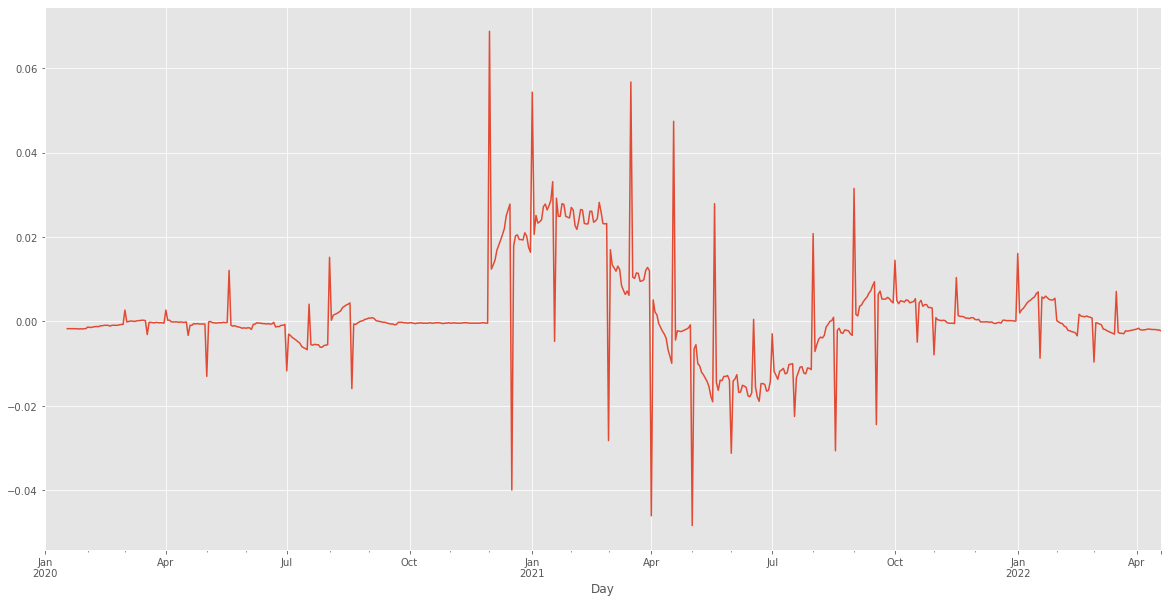

In [29]:
train_df['Seasonal First Difference'].plot()

<AxesSubplot:xlabel='Day'>

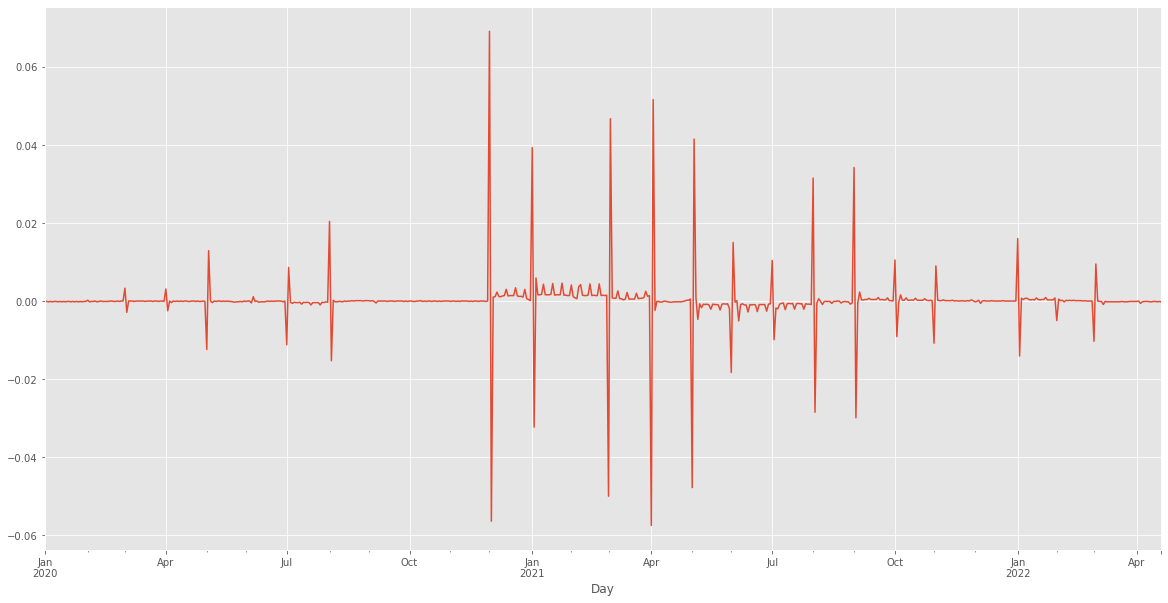

In [30]:
train_df['Deposit First Difference'].plot()

In [31]:
train_df['Deposit Second Differenc'] = train_df['Deposit First Difference'] - train_df['Deposit First Difference'].shift(1)

In [32]:
train_df['Deposit First Difference'].shift(1)

Day
2020-01-01       NaN
2020-01-02       NaN
2020-01-03   -0.0001
2020-01-06   -0.0002
2020-01-07   -0.0001
               ...  
2022-04-14   -0.0002
2022-04-15   -0.0001
2022-04-18   -0.0001
2022-04-19   -0.0002
2022-04-20   -0.0001
Name: Deposit First Difference, Length: 601, dtype: float64

In [33]:
train_df['Seasonal Second Difference']=train_df['Deposit First Difference']-train_df['Deposit First Difference'].shift(12)

In [34]:
train_df.head(14)

,OIS3M,OIS6M,OIS1Y,CBT,Deposit,Unnamed: 6,Deposit First Difference,Seasonal First Difference,Deposit Second Differenc,Seasonal Second Difference
Day,,,,,,,,,,
2020-01-01,0.1050,0.1050,0.1061,0.1149,0.0977,NaN,NaN,NaN,NaN,NaN
2020-01-02,0.1050,0.1050,0.1066,0.1149,0.0976,NaN,-0.0001,NaN,NaN,NaN
2020-01-03,0.1068,0.1068,0.1088,0.1129,0.0974,NaN,-0.0002,NaN,-0.0001,NaN
2020-01-06,0.1097,0.1102,0.1113,0.1144,0.0973,NaN,-0.0001,NaN,0.0001,NaN
2020-01-07,0.1106,0.1107,0.1111,0.1150,0.0971,NaN,-0.0002,NaN,-0.0001,NaN
2020-01-08,0.1100,0.1104,0.1109,0.1163,0.0970,NaN,-0.0001,NaN,0.0001,NaN
2020-01-09,0.1078,0.1079,0.1082,0.1165,0.0969,NaN,-0.0001,NaN,0.0000,NaN
2020-01-10,0.1053,0.1060,0.1064,0.1174,0.0967,NaN,-0.0002,NaN,-0.0001,NaN
2020-01-13,0.1037,0.1037,0.1040,0.1196,0.0966,NaN,-0.0001,NaN,0.0001,NaN


In [35]:
## Again test dickey fuller test
adfuller_test(train_df['Seasonal Second Difference'].dropna())

ADF Test Statistic : -9.612368005452867
p-value : 1.7974812394426427e-16
#Lags Used : 15
Number of Observations Used : 572
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<AxesSubplot:xlabel='Day'>

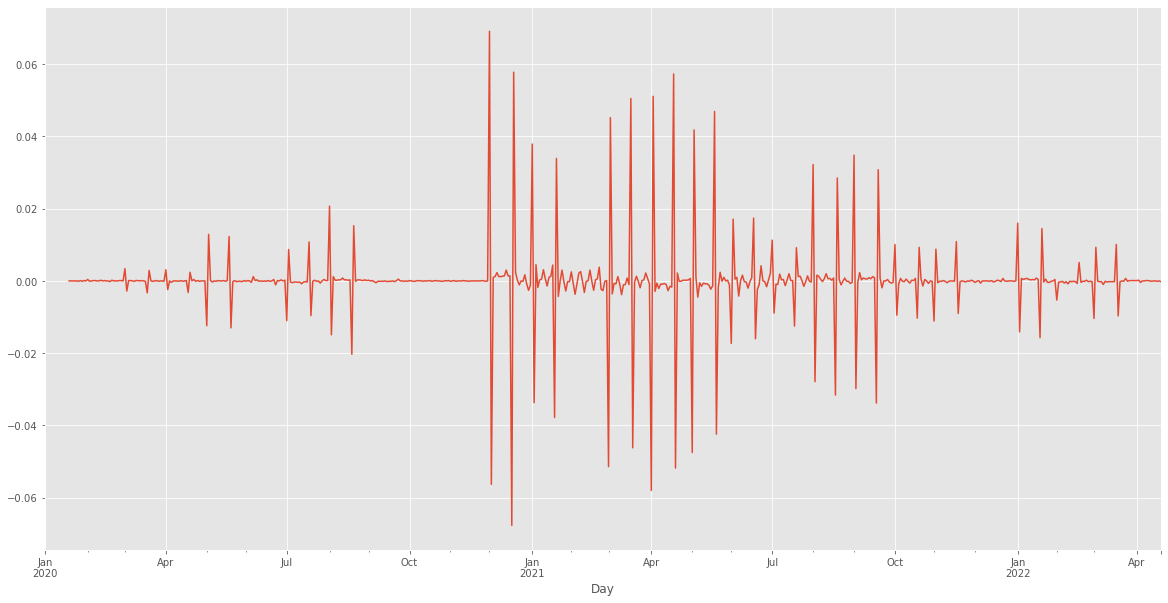

In [36]:
train_df['Seasonal Second Difference'].plot()

<AxesSubplot:xlabel='Day'>

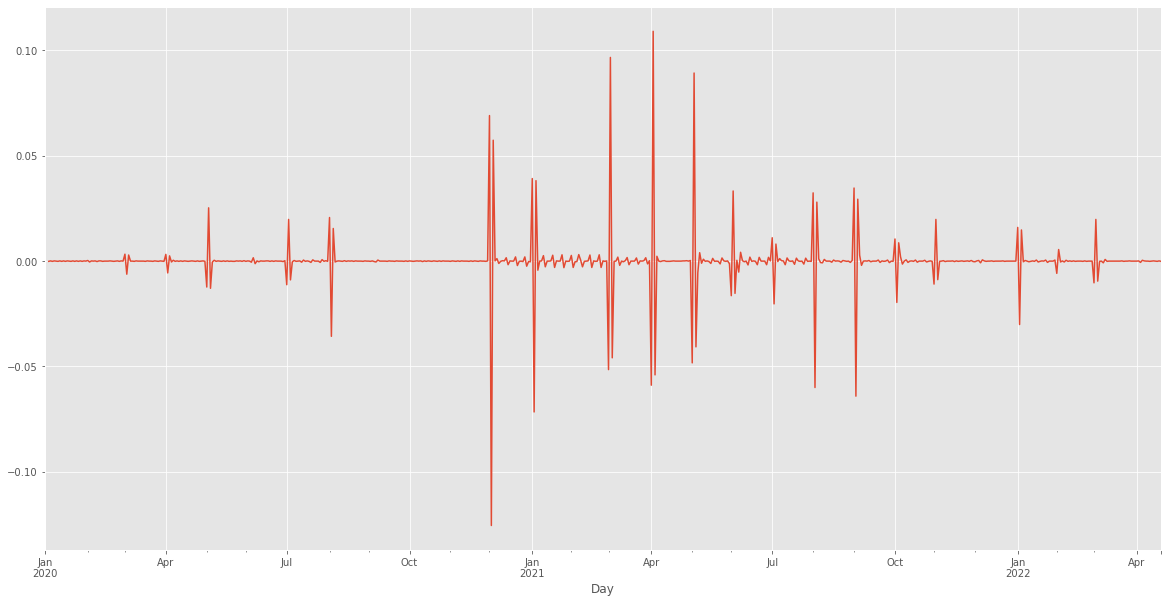

In [37]:
train_df['Deposit Second Differenc'].plot()

<a id="5"></a>
# 5) Auto Regressive Model

In [38]:
import statsmodels.api as sm

In [39]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

/Users/asliesi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


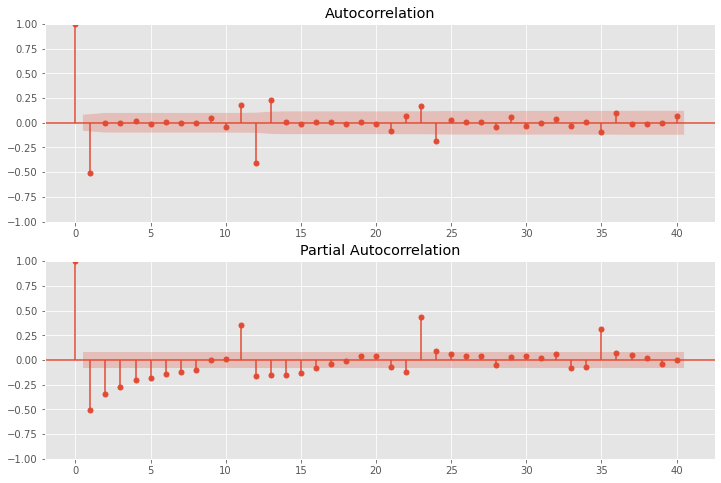

In [40]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_df['Seasonal Second Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_df['Seasonal Second Difference'].iloc[13:],lags=40,ax=ax2)

In [68]:
model2=ARIMA(train_df['Deposit'],order=(2,1,2))
model_fit2=model2.fit()

/Users/asliesi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'
/Users/asliesi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'


In [69]:
model_fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D.Deposit   No. Observations:                  600
Model:                 ARIMA(2, 1, 2)   Log Likelihood                2264.931
Method:                       css-mle   S.D. of innovations              0.006
Date:                Sun, 12 Mar 2023   AIC                          -4517.862
Time:                        18:29:21   BIC                          -4491.480
Sample:                    01-02-2020   HQIC                         -4507.592
                         - 04-20-2022                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            6.049e-05      0.000      0.186      0.853      -0.001       0.001
ar.L1.D.Deposit     1.0127      0.046     21.927      0.000       0.922       1.103
ar.L2.D.Deposit    -0.0272      0.046     -0.593      0.553      -0.117       0.063
ma.L1.D.Deposit    -1.8806      0.022    -86.645      0.000      -1.923      -1.838
ma.L2.D.Deposit     0.9036      0.021     42.774      0.000       0.862       0.945
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0151           +0.0000j            1.0151            0.0000
AR.2           36.1896           +0.0000j           36.1896            0.0000
MA.1            1.0407           -0.1541j            1.0520           -0.0234
MA.2            1.0407           +0.1541j            1.0520            0.0234
-----------------------------------------------------------------------------
"""

<AxesSubplot:xlabel='Day'>

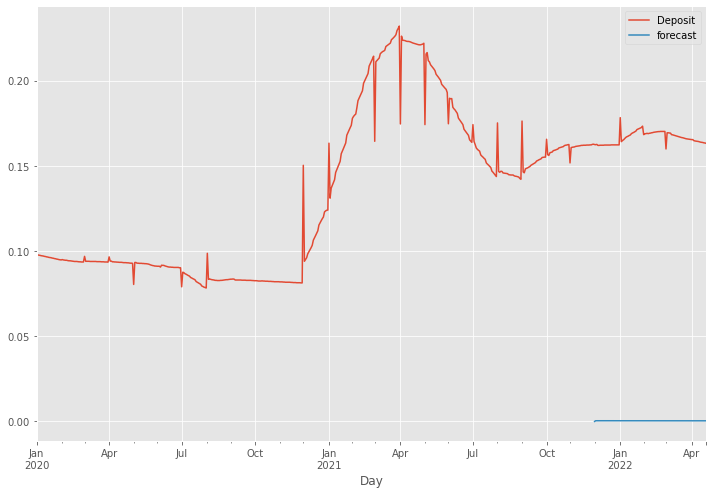

In [71]:
train_df['forecast']=model_fit2.predict(start=500,end=600,dynamic=True)
train_df[['Deposit','forecast']].plot(figsize=(12,8))

In [75]:
model2=sm.tsa.statespace.SARIMAX(train_df['Deposit'],order=(2, 1, 2),seasonal_order=(2,1,2,12))
results=model2.fit()

/Users/asliesi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'
/Users/asliesi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'
/Users/asliesi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot:xlabel='Day'>

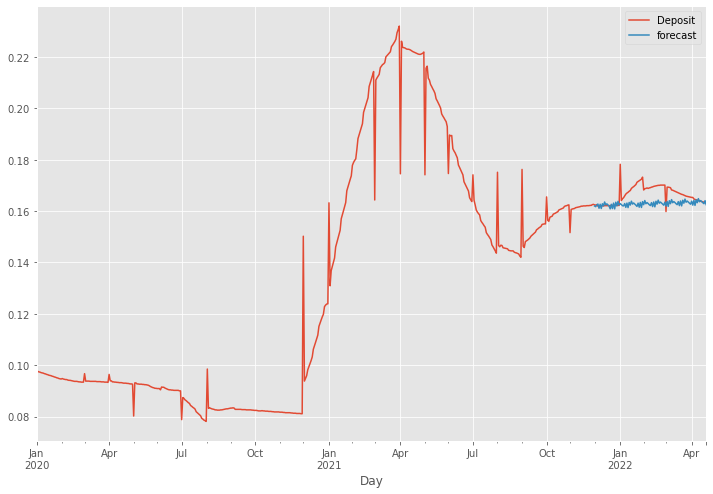

In [76]:
train_df['forecast']=results.predict(start=500,end=600,dynamic=True)
train_df[['Deposit','forecast']].plot(figsize=(12,8))

In [77]:
from pandas.tseries.offsets import DateOffset
future_dates=[train_df.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [78]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=train_df.columns)

In [79]:
future_datest_df.tail()

,OIS3M,OIS6M,OIS1Y,CBT,Deposit,Deposit First Difference,Seasonal First Difference,Deposit Second Differenc,Seasonal Second Difference,forecast
2023-11-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
future_df=pd.concat([train_df,future_datest_df])

<AxesSubplot:>

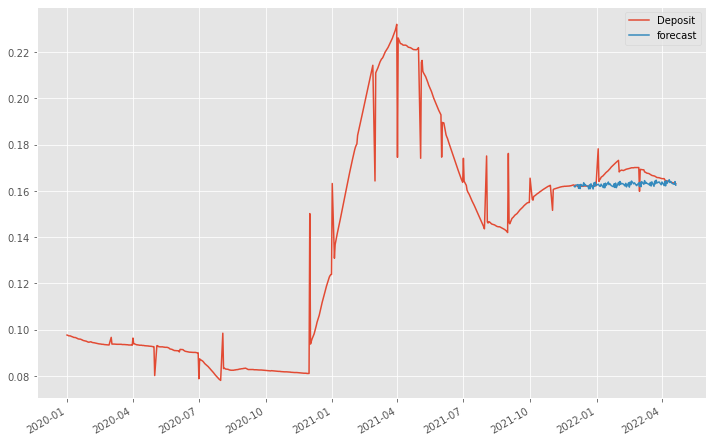

In [82]:
future_df['forecast'] = results.predict(start = 500, end = 620, dynamic= True)  
future_df[['Deposit', 'forecast']].plot(figsize=(12, 8)) 

In [90]:
train_df2 = train_df[['Deposit']]

In [91]:
train_df2

,Deposit
Day,
2020-01-01,0.0977
2020-01-02,0.0976
2020-01-03,0.0974
2020-01-06,0.0973
2020-01-07,0.0971
...,...
2022-04-14,0.1637
2022-04-15,0.1636
2022-04-18,0.1634


<a id="6"></a>
# 6) Linear Regression

In [54]:
df = train_df

In [55]:
df

,Day,OIS3M,OIS6M,OIS1Y,CBT,Deposit
0,2020-01-01,0.1050,0.1050,0.1061,0.1149,0.0977
1,2020-01-02,0.1050,0.1050,0.1066,0.1149,0.0976
2,2020-01-03,0.1068,0.1068,0.1088,0.1129,0.0974
3,2020-01-06,0.1097,0.1102,0.1113,0.1144,0.0973
4,2020-01-07,0.1106,0.1107,0.1111,0.1150,0.0971
...,...,...,...,...,...,...
596,2022-04-14,0.1610,0.1905,0.2365,0.1400,0.1637
597,2022-04-15,0.1575,0.1895,0.2365,0.1400,0.1636
598,2022-04-18,0.1575,0.1895,0.2372,0.1400,0.1634
599,2022-04-19,0.1590,0.1885,0.2357,0.1400,0.1633


##corr

In [32]:
df[['OIS3M','OIS6M','OIS1Y','CBT','Deposit']].corr()

,OIS3M,OIS6M,OIS1Y,CBT,Deposit
OIS3M,1.000000,0.962864,0.813386,0.760120,0.759284
OIS6M,0.962864,1.000000,0.935964,0.704577,0.762192
OIS1Y,0.813386,0.935964,1.000000,0.574160,0.717481
CBT,0.760120,0.704577,0.574160,1.000000,0.642283
Deposit,0.759284,0.762192,0.717481,0.642283,1.000000


#### hedef değişken deposit için açıklayıcı değişkenlerin hepsi birbirleriyle yüksek ilişkilidir.
#### Çoklu bağlantı sorunun önüne geçmek için tek değişken kullanılması gerekir.
#### Bu yüzden hedef değişken ile en yüksek ilişkili değişkeni OIS6M almamız gerekir. 
#### İki değişken kullanma durumunda CBT ve OIS1Y alınabilir. 

### Zamana bağlı bir veri seti olduğu için train test ayrımını tarihe göre yapmak daha doğru olur. Ancak çalışma veri seti olduğu için train test split ile 

## Model 1  - Tek değişken 

In [56]:
X = df[['OIS6M']]

In [57]:
y = df[['Deposit']]

In [58]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

In [59]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

LinearRegression()

In [60]:
y_pred = lin_reg.predict(X_test)

In [61]:
# coefficient 
print(lin_reg.coef_)

[[0.891602]]


In [62]:
# intercepts
print(lin_reg.intercept_)

[0.00090403]


In [63]:
# calculating the  R squared error
from sklearn.metrics import r2_score
r2_score(y_test,y_pred)

0.49111308550442756

## Model 2 - İki değişken 

In [64]:
X = df[['OIS1Y','CBT']]

In [65]:
y = df[['Deposit']]

In [66]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

In [67]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

LinearRegression()

In [68]:
y_pred = lin_reg.predict(X_test)

In [69]:
# coefficient 
print(lin_reg.coef_)

[[0.46793827 0.42349282]]


In [70]:
# intercepts
print(lin_reg.intercept_)

[0.00481512]


In [71]:
# calculating the  R squared error
from sklearn.metrics import r2_score
r2_score(y_test,y_pred)

0.42711706974898667